In [1]:
# Import packages

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Data summary

This data set represents 58 consecutive days of de-identified event data collected from five sources within Los Alamos National Laboratory’s corporate, internal computer network.

The data sources include Windows-based authentication events from both individual computers and centralized Active Directory domain controller servers; process start and stop events from individual Windows computers; Domain Name Service (DNS) lookups as collected on internal DNS servers; network flow data as collected on at several key router locations; and a set of well-defined red teaming events that present bad behavior within the 58 days. In total, the data set is approximately 12 gigabytes compressed across the five data elements and presents:

* 1,648,275,307 events in total for: 
    * 12,425 users, 
    * 17,684 computers, and 
    * 62,974 processes. 

## Our task

__Broad Project Scope__

The LANL cyber data set contains the authentication, process, network and DNS data of a network as it is infiltrated by a red team. The dataset is designed to serve as a realistic basis for the development of data science techniques for the detection of malicious activity within an enterprise computer network. The purpose of this project is to attempt to select and if necessary implement appropriate techniques for detecting suspicious activity within the dataset. In particular, the focus of this project is to detect actions of the red team through changes in DNS activity. 

The two main avenues of inquiry are:

1. to determine the roles of computers within the network as determinable from their DNS requests, and 
2. to identify significant changes in these roles from changes in DNS requests over the time period covered by the data set.

__Project Outcomes__

The deliverables for this project are:

* A manual analysis of the DNS data in conjunction with other parts of the LANL data set, in particular determining if there are any clear examples of compromise within the DNS data.
* Selection and application of a clustering technique of the DNS data to identify examples of machine role (such as server or desktop)
* Selection and application of time series analysis of the DNS data to identify state transitions within the dataset
* Code for the above analyses as implemented in ipython.
* A report and presentation, identifying the approaches taken above and the results of their application to the dataset.
* If time is remaining on the project following these analyses, further work can be undertaken combining the DNS data with other elements of the LANL dataset (authentication data, process data, etc).

### DNS dataset

From [https://csr.lanl.gov/data/cyber1/](https://csr.lanl.gov/data/cyber1/) - __dns.txt.gz__

This data presents Domain Name Service (DNS) lookup events collected from the central DNS servers within the network. Each event is on a separate line in the form of "time,source computer,computer resolved" and presents a DNS lookup at the given time by the source computer for the resolved computer and represents a likely network connection originating from the source computer to the resolved computer. The values are comma delimited and any fields that do not have a valid value are presented as a question mark ('?').

In [2]:
dns_headings = ['time','source_computer','computer_resolved']
dns = pd.read_csv('dns.txt', names=dns_headings, sep=',')

Example of supplied 'dns.txt' dataset

In [3]:
dns.head()

,time,source_computer,computer_resolved
0,2,C4653,C5030
1,2,C5782,C16712
2,6,C1191,C419
3,15,C3380,C22841
4,18,C2436,C5030


How many logs in the dataset?

In [4]:
dns.shape[0]

40821591

How many unique events/source computers/computers_resolved?

In [5]:
tm_unique = dns.time.nunique()
sc_unique = dns.source_computer.nunique()
urc_unique = dns.computer_resolved.nunique()
output = 'Unique timestamps: {0}\nUnique source computers: {1}\nUnique computers resolved: {2}'

print(output.format(tm_unique,sc_unique,urc_unique))

Unique timestamps: 3646743
Unique source computers: 15013
Unique computers resolved: 13776


### Examine as time series: by minute

The description says that there are 58 days of data.  The `time` variable is an integer value starting with 1.  Does this represent seconds?

In [6]:
# Check - if this variable represents seconds, does the dataset span 58 days?
span = max(dns.time) - min(dns.time)
secs_in_day = 60*60*24
days = span/secs_in_day
print(days)

57.9999652778


To estimate seasonality in the time series, summarise the number of logs in each minute, hour and day.

In [7]:
# Group each log into minute blocks
minute_blocks = np.arange(0,60*60*24*58,60)
req_per_min = dns.groupby(pd.cut(dns['time'], minute_blocks))['time'].count().to_frame()
req_per_min.columns = req_per_min.columns.str.replace('time', 'requests')
req_per_min['minute'] = req_per_min.index
req_per_min['minute'] = req_per_min['minute'].apply(lambda x: x.right / 60)

req_per_min.head()

,requests,minute
time,,
"(0, 60]",18,1.0
"(60, 120]",28,2.0
"(120, 180]",24,3.0
"(180, 240]",24,4.0
"(240, 300]",19,5.0


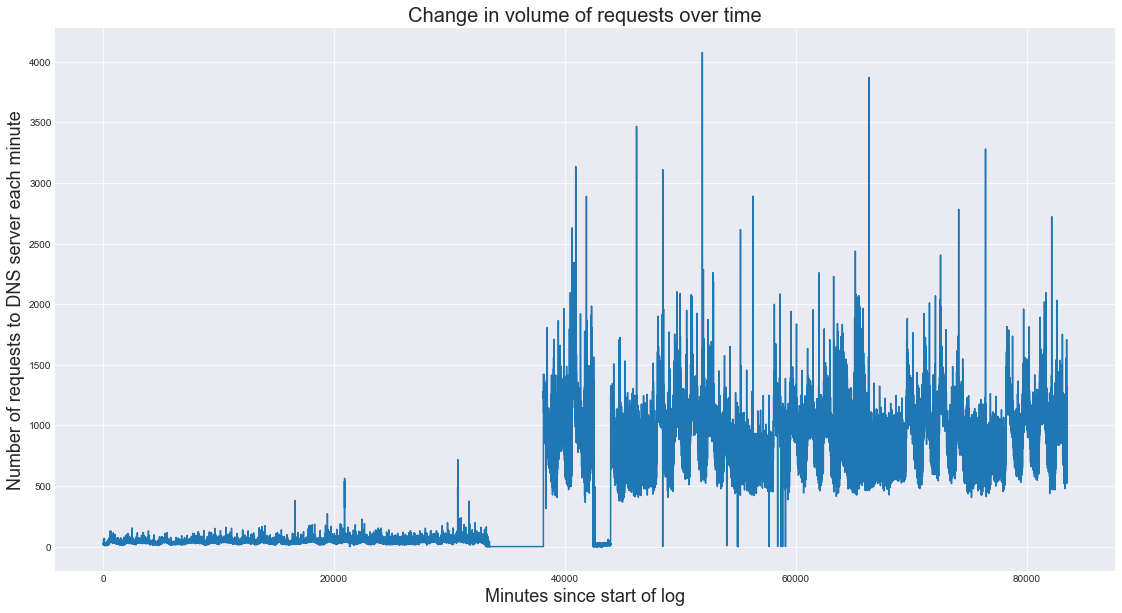

In [61]:
sns.set_style("darkgrid")

x = list(req_per_min['minute'].values)
y = req_per_min['requests'].values

fig = plt.figure(num=1, figsize=(19, 10))
plt.plot(x,y)
plt.title('Change in volume of requests over time',fontsize=20)
plt.xlabel('Minutes since start of log',fontsize=18)
plt.ylabel('Number of requests to DNS server each minute', fontsize=18);

### Classify computers as servers or desktops

Create a new table where each computer is a row and the variable `incoming` indicates the number requests to the DNS server for this computer.  Computers with high numbers of incoming requests are likely to be servers.

In [39]:
inc_reqs = pd.Series.to_frame(dns.groupby('computer_resolved')['source_computer'].count().sort_values(ascending=False))
inc_reqs = inc_reqs.reset_index()
inc_reqs.columns = inc_reqs.columns.str.replace('source_computer', 'incoming_requests')

In [40]:
inc_reqs.head()

,computer_resolved,incoming_requests
0,C1707,5374369
1,C1685,5224450
2,C5030,4658033
3,C586,4489267
4,C754,2417026


View the distribution of incoming requests for the top 50 computers

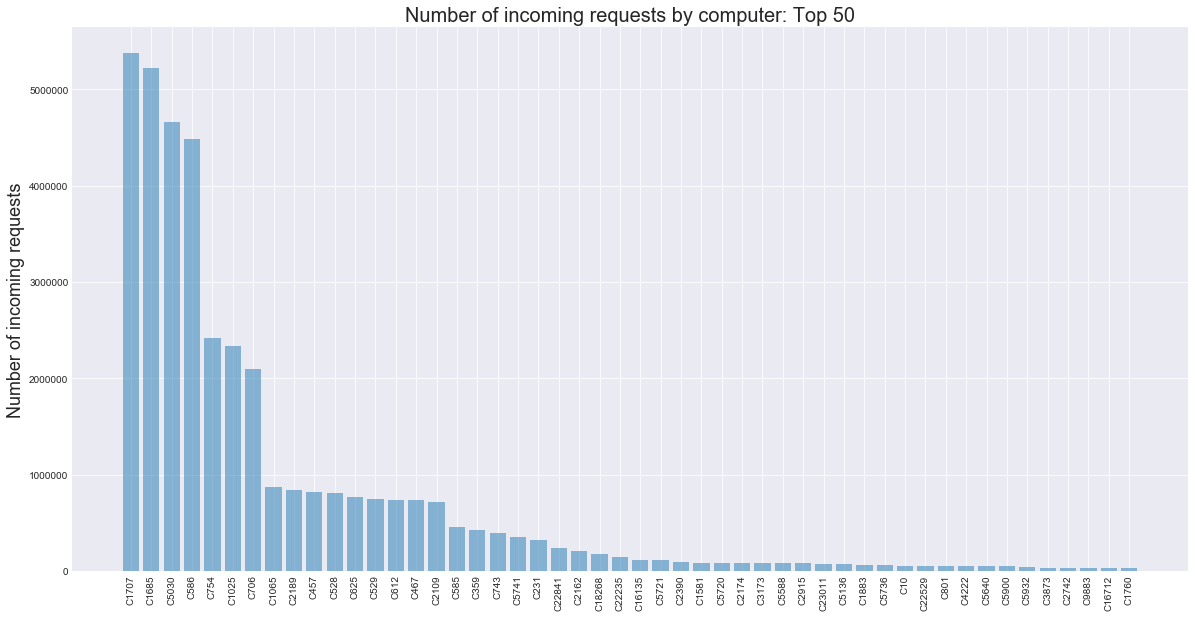

In [75]:
sns.set_style("darkgrid")

top_n = 50 # Change to view a larger or smaller number of top_n computers
title_label = 'Number of incoming requests by computer: Top ' + str(top_n)

computers = inc_reqs['computer_resolved'][0:top_n]
y_pos = np.arange(len(computers))
inc_req = inc_reqs['incoming_requests'][0:top_n]

fig2 = plt.figure(num=2, figsize=(20,10))
plt.bar(y_pos, inc_req, align='center', alpha=0.5)
plt.xticks(y_pos, computers)
plt.xticks(rotation=90)
plt.ylabel('Number of incoming requests',fontsize=18)
plt.title(title_label,fontsize=20);

Ranked by incoming traffic, the first four computers appear to have similarly high usage, followed by the next three, then the next 9.

__Create directed graph from log__

One way to interpret the dataset as a graph using the NetworkX package - documentation in pdf format [here](https://networkx.github.io/).

With this data structure:

* Each computer (whether `source_computer` or `computer_resolved`) is a node;
* Each lookup request, represented by one row in the table, is a directed edge;
* The time of each lookup request is recorded as an attribute of the edge.

In [ ]:
# This takes a while - 2-3 minutes on my desktop (i5, 3.50GHz, 4-core, 32GB memory)
%%time
dns_graph = nx.MultiDiGraph()
dns_graph.add_weighted_edges_from([tuple(d) for d in dns[['source_computer','computer_resolved','time']].values])       

In [ ]:
type(dns_graph)

In [ ]:
dns_graph.in_edges()

In [ ]:
help("networkx.edges_iter")

In [ ]:
%%time
dns_graph.edges(data=True)[0:5]

Using this format, all requests to and from each computer in a particular timeframe can be visualised.  

In the example plot below, all interactions in the first 5 minutes of the database are visualised.

In [ ]:
def betw_tm(graph,start,stop):
    edges = graph.edges(data=True)
    return [i for i in edges if start <= i[2]['weight'] <= stop]

In [ ]:
%%time
first_5_min = betw_tm(dns_graph,0,5*60)

In [ ]:
%pylab inline

#pylab.rcParams['figure.figsize'] = (18, 18)
#nx.draw_networkx(first_5_min, arrows=True, alpha=0.15)

Following Siadati, Saket & Memon (2016) below, it may be useful to classify computers as desktops and servers based on the level of inbound requests they receive.

## Redteam dataset

Also from [https://csr.lanl.gov/data/cyber1/](https://csr.lanl.gov/data/cyber1/) - __readteam.txt.gz__ This data presents specific events taken from the authentication data that present known redteam compromise events. These may be used as ground truth of bad behavior that is different from normal user and computer activity. Each event is on a separate line in the form of "time,user@domain,source computer,destination computer" and presents a compromise event at the given time. The values are comma delimited.

In [ ]:
# Import dataset
rt_headings = ['time','user@domain','source_computer','destination_computer']
redteam = pd.read_csv('redteam.txt.gz', compression='gzip', names=rt_headings, sep=',')

How many rows in this log?

In [ ]:
redteam.shape[0]

In [ ]:
# SHow example
redteam.head()

Create a new variable in the dns log to identify if the `source_computer` for that event appears in the the redteam log

In [ ]:
dns['in_redteam'] = dns.computer_resolved.isin(redteam.source_computer)

How many logs include the source computer named in the redteam log?

In [ ]:
len(dns[dns.in_redteam == True])

It would also be interesting to view this dataset as a directed graph

In [ ]:
rt_graph = nx.MultiDiGraph()
rt_graph.add_weighted_edges_from([tuple(d) for d in redteam[['source_computer','destination_computer','time']].values])  

In [ ]:
%pylab inline

pylab.rcParams['figure.figsize'] = (18, 18)

nx.draw_networkx(rt_graph, arrows=True, alpha=0.15)

In [ ]:
type(rt_graph)

In [ ]:
for u,v,d in rt_graph.edges(data=True):
    d['label'] = d.get('weight','')
    
A = pydot.graph_from_edges(rt_graph)
A.layout(prog='dot')
A.draw('test.png')

In [ ]:
rt_graph = nx.DiGraph() # This probably needs to be a MultiDiGraph to allow multiple timestamps
rt_graph = nx.from_pandas_dataframe(redteam,'source_computer','destination_computer',edge_attr='time',create_using=rt_graph)

In [ ]:
rt_graph.get_edge_data("C17693","C1003")

In [ ]:
%pylab inline

pylab.rcParams['figure.figsize'] = (18, 18)

nx.draw_networkx(rt_graph, arrows=True, alpha=0.15)

One interpretation of the plot above is that C17693,C18025 and C19932 were infiltrated.  Using this access, credentials for C19932 were obtained. Using access to C19932, root access to the server (C17693) was obtained through C586, C529 or C625.

Another attempted infiltration, via C1493 and/or C18025 was unsuccessful.

## Ideas from literature

__Siadati, Saket & Memon (2016) "Detecting malicious logins in enterprise networks using visualization"__

* Partition the logins into days and compute the summary of login events - groupby [user,source,destination].count() for each day
* Use the login events that happen more than 10% of the days to form a model which helps track changes in network structure
* Classify computers into 'global-server', 'local-server' and 'desktop' based on how frequently they are the destination of logins
* After this
    * desktop-to-desktop connections are suspicious
    * find anomalous logins based on unusual times, frequencies and high rates of login failures

__Heard & Rubin-Delanchy (2016)__ "Network-wide anomaly detection via the Dirichlet process"

* 